<a href="https://colab.research.google.com/github/Hong-gi-young/Projects/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### automl efficientdet 다운로드 및 설치

In [ ]:
!git clone --depth 1 https://github.com/chulminkw/automl

Cloning into 'automl'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 147 (delta 14), reused 19 (delta 0), pack-reused 0
Receiving objects: 100% (147/147), 9.62 MiB | 18.21 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-itqzlci3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-itqzlci3
     |████████████████████████████████| 6.3 MB 7.3 MB/s 
     |████████████████████████████████| 636 kB 31.6 MB/s 
     |████████████████████████████████| 1.1 MB 40.0 MB/s 
     |████████████████████████████████| 120 kB 73.1 MB/s 
     |████████████████████████████████| 211 kB 76.0 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263922 sha256=36934ea831fb1468372b0fcd0523389be117c61ba72945b2d30fcd4e58e91e52
  Stored in directory: /tmp/pip-ephem-wheel-cache-cleri5h9/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: pycocotools
    Found exi

In [ ]:
# !pip uninstall -y keras

In [ ]:
!nvidia-smi

Fri Aug 20 23:31:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import sys
import tensorflow.compat.v1 as tf #tensor 버전 1

sys.path.append('/content/automl/efficientdet')

import hparams_config 
from _keras import anchors
from model_inspect import ModelInspector

### face Object Detection Dataset 다운로드 및 파일 살펴 보기

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [ ]:
!cd /mydrive/Colab\ Notebooks/Datasets
!mkdir -p /content/face
!unzip -uq /mydrive/Colab\ Notebooks/Datasets/archive.zip -d /content/face

In [ ]:
ANNO_DIR = '/content/face/annotations'
file_list = os.listdir(ANNO_DIR)
file_list = sorted([file for file in file_list if file.endswith('.xml')])
print(len(file_list))
print(file_list)

853
['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml', 'maksssksksss100.xml', 'maksssksksss101.xml', 'maksssksksss102.xml', 'maksssksksss103.xml', 'maksssksksss104.xml', 'maksssksksss105.xml', 'maksssksksss106.xml', 'maksssksksss107.xml', 'maksssksksss108.xml', 'maksssksksss109.xml', 'maksssksksss11.xml', 'maksssksksss110.xml', 'maksssksksss111.xml', 'maksssksksss112.xml', 'maksssksksss113.xml', 'maksssksksss114.xml', 'maksssksksss115.xml', 'maksssksksss116.xml', 'maksssksksss117.xml', 'maksssksksss118.xml', 'maksssksksss119.xml', 'maksssksksss12.xml', 'maksssksksss120.xml', 'maksssksksss121.xml', 'maksssksksss122.xml', 'maksssksksss123.xml', 'maksssksksss124.xml', 'maksssksksss125.xml', 'maksssksksss126.xml', 'maksssksksss127.xml', 'maksssksksss128.xml', 'maksssksksss129.xml', 'maksssksksss13.xml', 'maksssksksss130.xml', 'maksssksksss131.xml', 'maksssksksss132.xml', 'maksssksksss133.xml', 'maksssksksss134.xml', 'maksssksksss135.xml', 'maksssksksss136.xml', 'maksssksksss1

In [ ]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import math
import matplotlib.pyplot as plt
import cv2

def get_anno_dict_from_xml(xml_file):
  # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bbox_names=[]
  objects=[]

  filename=root.find('filename').text
  size= root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)

  for obj in root.findall('object'):
    name = obj.find('name').text
    pose='Unspecified'
    truncated = 0
    difficult = 0
    occluded = 0    
   
    #BB정보 가져오기
    xmlbox =obj.find('bndbox')
    xmin = int(xmlbox.find('xmin').text)
    ymin = int(xmlbox.find('ymin').text)
    xmax = int(xmlbox.find('xmax').text)
    ymax = int(xmlbox.find('ymax').text)
    bbox = {
        'xmin':xmin,
        'ymin':ymin,
        'xmax':xmax,
        'ymax':ymax
    }
    single_obj ={'name':name, 'pose':pose, 'truncated':truncated,
               'difficult':difficult,'occluded':occluded,
               'bndbox':bbox}
    objects.append(single_obj)

  anno_dict={
      'folder':'annotations','filename':filename,'width':width,
      'height':height, 'object':objects
  }      

  return anno_dict

In [ ]:
anno_dic = get_anno_dict_from_xml(ANNO_DIR+'/'+file_list[0])
anno_dic['object']

[{'bndbox': {'xmax': 109, 'xmin': 79, 'ymax': 142, 'ymin': 105},
  'difficult': 0,
  'name': 'without_mask',
  'occluded': 0,
  'pose': 'Unspecified',
  'truncated': 0},
 {'bndbox': {'xmax': 226, 'xmin': 185, 'ymax': 144, 'ymin': 100},
  'difficult': 0,
  'name': 'with_mask',
  'occluded': 0,
  'pose': 'Unspecified',
  'truncated': 0},
 {'bndbox': {'xmax': 360, 'xmin': 325, 'ymax': 141, 'ymin': 90},
  'difficult': 0,
  'name': 'without_mask',
  'occluded': 0,
  'pose': 'Unspecified',
  'truncated': 0}]

In [ ]:
# image와 object의 고유 id 부여. 
class Unique_Id(object):

  def __init__(self):
    self.image_id = 0
    self.ann_id = 0

  def get_image_id(self):
    self.image_id +=1
    return self.image_id
  
  def get_ann_id(self):
    self.ann_id +=1
    return self.ann_id

In [ ]:
import tensorflow as tf
from dataset import tfrecord_util

# 인자로 들어온 dict에 따라 tf.train.Example을 생성. 
def make_tfrecord_example(example_dict):
  example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/height': tfrecord_util.int64_feature(example_dict['height']),
                'image/width': tfrecord_util.int64_feature(example_dict['width']),
                'image/filename': tfrecord_util.bytes_feature(example_dict['filename']),
                'image/source_id': tfrecord_util.bytes_feature(example_dict['source_id']),
                'image/key/sha256': tfrecord_util.bytes_feature(example_dict['key_sha256']),
                'image/encoded': tfrecord_util.bytes_feature(example_dict['encoded']),
                'image/format': tfrecord_util.bytes_feature('PNG'.encode('utf8')),
                'image/object/bbox/xmin': tfrecord_util.float_list_feature(example_dict['xmin']),
                'image/object/bbox/xmax': tfrecord_util.float_list_feature(example_dict['xmax']),
                'image/object/bbox/ymin': tfrecord_util.float_list_feature(example_dict['ymin']),
                'image/object/bbox/ymax': tfrecord_util.float_list_feature(example_dict['ymax']),
                'image/object/area': tfrecord_util.float_list_feature(example_dict['area']),
                'image/object/class/text': tfrecord_util.bytes_list_feature(example_dict['class_text']),
                'image/object/class/label': tfrecord_util.int64_list_feature(example_dict['class_label']),
                'image/object/difficult': tfrecord_util.int64_list_feature(example_dict['difficult']),
                'image/object/truncated': tfrecord_util.int64_list_feature(example_dict['truncated']),
                'image/object/view': tfrecord_util.bytes_list_feature(example_dict['poses']),
            }))
  
  return example


In [ ]:
import hashlib
import io
import json
import os
import PIL.Image
import tensorflow as tf
from dataset import tfrecord_util

# 1개의 image 파일 PATH와 1개의 annotation XML 정보를 가지는 data dic를 이용하여 tf.train.Example를 생성. 
def dict_to_tf_example(anno, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None, debug=True):
  
  # JPEG image를 binary 그대로 읽음. 
  # tf.gfile.GFile( ) 은 파이썬의 open( ) 이랑 사용법이 완전히 일치한다
  with tf.io.gfile.GFile(image_path, 'rb') as fid:
    encoded_png= fid.read()
  
  #image가 png 타입인지 확인
  encoded_png_io =io.BytesIO(encoded_png)
  image = PIL.Image.open(encoded_png_io)

  if image.format != 'PNG':
    raise ValueError('Image format not png')

  #image의 고유 key 값 생성
  key = hashlib.sha256(encoded_png).hexdigest()

  #고유한 image id 생성
  image_id = unique_id.get_image_id()
  # image의 width,height 가져오기
  width = int(anno['width'])
  height =int(anno['height'])

 #각 객체마다 같은 속성끼리 list를 만드므로 각각 list로 만들어야한다. 
  xmins, ymins, xmaxes, ymaxes = [], [], [], []
  areas, classes, classes_texts = [], [], []
  truncated, poses, difficult_obj = [], [], []
  # 만일 annotation에 1개 이상의 object가 있다면, 
  if 'object' in anno:
    for obj in anno['object']: #anno['object'] : [객체1,객체2,객체3,.., 객체n]
      difficult = bool(int(obj['difficult'])) #bool(0) -> false가 출력  
      if ignore_difficult_instances and difficult: #둘다 True이면 for문으로 back
        continue
      if obj['name'] not in label_map_dict:
        continue

      difficult_obj.append(difficult)
      # 개별 좌표 값을 이미지의 크기로 정규화하고 list 저장
      xmins.append(float(obj['bndbox']['xmin']) / width)
      ymins.append(float(obj['bndbox']['ymin']) / height)
      xmaxes.append(float(obj['bndbox']['xmax']) / width)
      ymaxes.append(float(obj['bndbox']['ymax']) / height)
      areas.append((xmaxes[-1] - xmins[-1]) * (ymaxes[-1] - ymins[-1])) #width*height

      #class 명과 class_id를 list 저장 
      classes_texts.append(obj['name'].encode('utf8')) #문자열은 모두 .encode('utf8') 적용해야함
      classes.append(label_map_dict[obj['name']])
      # truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 저장. 
      truncated.append(int(obj['truncated']))
      poses.append(obj['pose'].encode('utf8'))
      difficult_obj.append(obj['difficult'])

  example_dict = {'height':height, 'width':width, 'filename':anno['filename'].encode('utf8'),
                  'source_id': str(image_id).encode('utf8'), 'key_sha256': key.encode('utf8'),
                  'encoded': encoded_png, 'format':'PNG'.encode('utf8'),
                  'xmin':xmins, 'xmax':xmaxes, 'ymin':ymins, 'ymax':ymaxes,
                  'area':areas, 'class_text':classes_texts, 'class_label':classes,
                  'difficult':difficult_obj, 'truncated':truncated, 'poses':poses}

  if debug:
   print('example_dict:', example_dict) 

  example = make_tfrecord_example(example_dict)

  return example                


In [ ]:
label_map_dict = {
    'with_mask': 1,
    'without_mask': 2
}

unique_id =Unique_Id()
number= 0
anno = get_anno_dict_from_xml(ANNO_DIR+'/'+file_list[number])
print('xml 파일을 dict 형태로 변경한 결과:', anno)
image_path =  '/content/face/images/'+file_list[number].split('.')[0]+'.png'
example = dict_to_tf_example(anno,image_path, label_map_dict , unique_id, ignore_difficult_instances=False, ann_json_dict=None)

xml 파일을 dict 형태로 변경한 결과: {'folder': 'annotations', 'filename': 'maksssksksss0.png', 'width': 512, 'height': 366, 'object': [{'name': 'without_mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 79, 'ymin': 105, 'xmax': 109, 'ymax': 142}}, {'name': 'with_mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 185, 'ymin': 100, 'xmax': 226, 'ymax': 144}}, {'name': 'without_mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 325, 'ymin': 90, 'xmax': 360, 'ymax': 141}}]}
example_dict: {'height': 366, 'width': 512, 'filename': b'maksssksksss0.png', 'source_id': b'1', 'key_sha256': b'9644ec494f2bb0bf09fa65ccaeefdbd2bafa2ba78cced5eba617e9f6590c364d', 'encoded': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x01n\x08\x02\x00\x00\x00x\x0c7\x1a\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00DeXIfMM\x00*\x00\x00\x00\x08\x00\x01\x87i\x00\x04\x00\x00\x00

In [ ]:
example

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\002\000\000\000\001n\010\002\000\000\000x\0147\032\000\000\000\001sRGB\000\256\316\034\351\000\000\000DeXIfMM\000*\000\000\000\010\000\001\207i\000\004\000\000\000\001\000\000\000\032\000\000\000\000\000\003\240\001\000\003\000\000\000\001\000\001\000\000\240\002\000\004\000\000\000\001\000\000\002\000\240\003\000\004\000\000\000\001\000\000\001n\000\000\000\000\253n\016\007\000\000@\000IDATx\001\324\335\207\266d;r&\346\364\366\2702\327u\223lj\226\334\033\350\261\264\264\226\036V\263d(q\310aw_SU\307\245\317\324\367\0072\263\262NU\3356\344\014%\334\272y\260\261a\002\201@D \020\300\356\376/\377\363\377\272\333\355\036\037\037w\273M\247\3239$\354\026\213\305\363r5\032\2156\233\315\363\323r\273O\020?\354\273\253\375\266\233p\330u\016\335N\2777\030\216\206\223\301h$\303t:\355\r\373\302`0\350\366{\362\'e0\236\315f\235Co<\036\367\207\243A\177\244\201\311dz

### 학습과 검증용 TFRecord 파일들을 생성. 
* 학습과 검증용 DataFrame으로 학습, 검증 데이터세트 분류
* 개별 Example을 생성하는 dict_to_tf_example()을 이용하여 모든 데이터 세트를 TFRecord로 생성. 

In [ ]:
file_id_list = [file.split('.')[0] for file in file_list]
len(file_id_list)

853

In [ ]:
import pandas as pd
path='/content/face/'
data_df = pd.DataFrame(file_id_list, columns=['file_id'])
data_df['image_path']=path+'images/'+data_df['file_id']+'.png'
data_df['xml_path']=path+'annotations/'+data_df['file_id']+'.xml'
data_df

,file_id,image_path,xml_path
0,maksssksksss0,/content/face/images/maksssksksss0.png,/content/face/annotations/maksssksksss0.xml
1,maksssksksss1,/content/face/images/maksssksksss1.png,/content/face/annotations/maksssksksss1.xml
2,maksssksksss10,/content/face/images/maksssksksss10.png,/content/face/annotations/maksssksksss10.xml
3,maksssksksss100,/content/face/images/maksssksksss100.png,/content/face/annotations/maksssksksss100.xml
4,maksssksksss101,/content/face/images/maksssksksss101.png,/content/face/annotations/maksssksksss101.xml
...,...,...,...
848,maksssksksss95,/content/face/images/maksssksksss95.png,/content/face/annotations/maksssksksss95.xml
849,maksssksksss96,/content/face/images/maksssksksss96.png,/content/face/annotations/maksssksksss96.xml
850,maksssksksss97,/content/face/images/maksssksksss97.png,/content/face/annotations/maksssksksss97.xml
851,maksssksksss98,/content/face/images/maksssksksss98.png,/content/face/annotations/maksssksksss98.xml


In [ ]:
from sklearn.model_selection import train_test_split

# 전체 데이터의 20%을 검증용으로 사용
train_df,val_df =train_test_split(data_df, test_size=0.2, random_state=2021)
print(train_df.shape,val_df.shape)

(682, 3) (171, 3)


In [ ]:
# 모든 image/xml 파일들을 TFRecord로 생성. 
def make_tfrecords(meta_df, output_dir, output_prefix, num_shards):
  xml_list=meta_df['xml_path'].to_list()
  image_list=meta_df['image_path'].to_list()

  unique_id= Unique_Id()
  writers =[
           tf.io.TFRecordWriter(output_dir+output_prefix+ '-%05d-of-%05d.tfrecord' %(i, num_shards)) for i in range(num_shards)
  ]
  for idx, xml_path in enumerate(xml_list):
    if idx % 100 == 0:
      print('On image ', idx, 'of', len(xml_list))
    anno = get_anno_dict_from_xml(xml_path)
    image_path = image_list[idx]

    #개별 Example 생성
    tf_example = dict_to_tf_example(anno, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None, debug=False)
    # num_shard만큼 만들어진 TFRecord에 Example을 iteration을 수행하면서 해당하는 TFRecord로 append 
    writers[idx % num_shards].write(tf_example.SerializeToString())

  # num_shards 만큼 만들어진 TFRecordWriter 객체 close
  for writer in writers:
    writer.close()

In [ ]:
!mkdir -p /content/tfrecord/train
!mkdir -p /content/tfrecord/val

In [ ]:
print('#### train용 tfrecords 생성 시작 ####')
make_tfrecords(train_df, '/content/tfrecord/train/', 'train', num_shards=100) 

print('#### val용 tfrecords 생성 시작 ####')  
make_tfrecords(val_df, '/content/tfrecord/val/', 'val', num_shards=100)

#### train용 tfrecords 생성 시작 ####
On image  0 of 682
On image  100 of 682
On image  200 of 682
On image  300 of 682
On image  400 of 682
On image  500 of 682
On image  600 of 682
#### val용 tfrecords 생성 시작 ####
On image  0 of 171
On image  100 of 171


In [ ]:
!ls -lia /content/tfrecord/train
!ls -lia /content/tfrecord/va

total 325984
2359301 drwxr-xr-x 2 root root    4096 Aug 20 23:32 .
2359300 drwxr-xr-x 4 root root    4096 Aug 20 23:32 ..
2359303 -rw-r--r-- 1 root root 3420066 Aug 20 23:32 train-00000-of-00100.tfrecord
2359304 -rw-r--r-- 1 root root 3790727 Aug 20 23:32 train-00001-of-00100.tfrecord
2359305 -rw-r--r-- 1 root root 4044072 Aug 20 23:32 train-00002-of-00100.tfrecord
2359306 -rw-r--r-- 1 root root 2882268 Aug 20 23:32 train-00003-of-00100.tfrecord
2359307 -rw-r--r-- 1 root root 3365425 Aug 20 23:32 train-00004-of-00100.tfrecord
2359308 -rw-r--r-- 1 root root 2948470 Aug 20 23:32 train-00005-of-00100.tfrecord
2359309 -rw-r--r-- 1 root root 3466234 Aug 20 23:32 train-00006-of-00100.tfrecord
2359310 -rw-r--r-- 1 root root 3035154 Aug 20 23:32 train-00007-of-00100.tfrecord
2359311 -rw-r--r-- 1 root root 3654889 Aug 20 23:32 train-00008-of-00100.tfrecord
2359312 -rw-r--r-- 1 root root 3462955 Aug 20 23:32 train-00009-of-00100.tfrecord
2359313 -rw-r--r-- 1 root root 3897148 Aug 20 23:32 train-

### Pretrained 모델을 다운로드 받고 Train을 위한 config 생성

In [ ]:
!mkdir -p /checkpoint/model_trained_d2

In [ ]:
MODEL='efficientdet-d2'

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(),m)
  return ckpt_path  

ckpt_path = download(MODEL)
os.listdir()

--2021-08-20 23:32:32--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d2.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60307996 (58M) [application/octet-stream]
Saving to: ‘efficientdet-d2.tar.gz’

efficientdet-d2.tar 100%[===================>]  57.51M  60.2MB/s    in 1.0s    

2021-08-20 23:32:34 (60.2 MB/s) - ‘efficientdet-d2.tar.gz’ saved [60307996/60307996]



['.config',
 'efficientdet-d2.tar.gz',
 'face',
 'efficientdet-d2',
 'gdrive',
 'automl',
 'tfrecord',
 'sample_data']

In [ ]:
class TRAIN_CFG:
  model_name = 'efficientdet-d2'
  strategy = ''
  model_dir='/content/checkpoint/model_trained_d2'
  pretrained_ckpt='/content/efficientdet-d2'
  hparams = 'num_classes=2,moving_average_decay=0,mixed_precision=true'
  use_xla = False
  use_fake_data = False
  batch_size = 4
  eval_samples = 5000 # evaluation image 데이터 갯수
  steps_per_execution = 1 # train 시 steps 횟수
  num_examples_per_epoch = 3000 # 1 epochs 시 적용하는 examples 개수 
  num_epochs = 100 # epochs 횟수
  train_file_pattern = '/content/tfrecord/train/train-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_file_pattern = '/content/tfrecord/val/val-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_json_file = None # optional coco validation json 
  mode = 'traineval' # train만 적용 또는 train과 eval함께 적용(traineval)
  num_shards = 100 
  # max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음. 200으로 수정. 
  max_instances_per_image = 200
  
  num_cores = 2 # tpu 일때 8 적용.  
  tpu = None
  gcp_project = None
  tpu_zone = None
  eval_master = ''
  eval_name = None
  tf_random_seed = 2021
  profile = False
  debug = False


In [ ]:
from _keras.train import setup_model
import hparams_config

import utils
from _keras import tfmot
from _keras import train_lib
from _keras import util_keras

config =hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch = TRAIN_CFG.num_examples_per_epoch // TRAIN_CFG.batch_size

if tf.config.list_physical_devices('GPU'):
  ds_strategy = tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
  ds_strategy = tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)

params = dict(
      profile=TRAIN_CFG.profile,
      mode = TRAIN_CFG.mode,
      model_name=TRAIN_CFG.model_name,
      steps_per_execution=TRAIN_CFG.steps_per_execution,
      num_epochs = TRAIN_CFG.num_epochs,
      model_dir=TRAIN_CFG.model_dir,
      steps_per_epoch=steps_per_epoch,
      strategy=TRAIN_CFG.strategy,
      batch_size=TRAIN_CFG.batch_size,
      tf_random_seed=TRAIN_CFG.tf_random_seed,
      debug=TRAIN_CFG.debug,
      val_json_file=TRAIN_CFG.val_json_file,
      eval_samples=TRAIN_CFG.eval_samples,
      num_shards=ds_strategy.num_replicas_in_sync,
      # max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음. 200으로 수정.
      max_instances_per_image = TRAIN_CFG.max_instances_per_image
      )

config.override(params, True)

# image size를 tuple 형태로 변환, ex) '1920x880' 은 (1920, 880) 으로 변환.  
config.image_size = utils.parse_image_size(config.image_size)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b2
batch_size: 4
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
eval_samples: 5000
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 5
fpn_config: null
fpn_name: null
fpn_num_filters: 112
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 768
- 768
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_insta

### Dataset과 Model 생성하고 학습 수행. 
* 앞에서 만든 train과 val용 TFRecord를 이용하여 dataloader.InputReader를 생성하는 함수 생성.
* efficientdet-d2 모델 생성 후 pretrained 모델의 weight 전이.
* batch_size 4로 설정. 8로 설정 시 GPU Memory OOM 발생 가능성 높음(Out Of Memory), epochs 20으로 학습 수행. 

In [ ]:
import dataloader

def get_dataset(is_training, config):
  file_pattern = (
      TRAIN_CFG.train_file_pattern if is_training else TRAIN_CFG.val_file_pattern
  )
  if not file_pattern:
    raise ValueError('No matching files.')
  
  return dataloader.InputReader(
      file_pattern,
      is_training = is_training,
      use_fake_data=TRAIN_CFG.use_fake_data,
      max_instances_per_image =config.max_instances_per_image,
      debug=TRAIN_CFG.debug)(config.as_dict())

In [ ]:
from _keras import train_lib
from _keras import train

def get_efficient_model(config):
  model = train_lib.EfficientDetNetTrain(config=config)
  model = train.setup_model(model, config)
  if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net']
    )
    train.init_experimental(config)
    return model
model = get_efficient_model(config)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      multiple                  7267314   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  39984     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  678479    
_________________________________________________________________
class_net (ClassNet)         multiple                  50754     
_________________________________________________________________
box_net (BoxNet)             multiple                  52788     
Total params: 8,089,319
Trainable params: 8,007,543
Non-trainable params: 81,776
___________________________________________________

In [ ]:
print(config.mode)

traineval


In [ ]:
from _keras import train
import numpy as np

config.batch_size = 4 
tr_steps_per_epoch = train_df.shape[0]//config.batch_size
val_steps_per_epoch = val_df.shape[0]//config.batch_size
print('tr_steps_per_epoch:', tr_steps_per_epoch, 'val_steps_per_epoch:', val_steps_per_epoch)

val_dataset = get_dataset(False,config) if 'eval' in config.mode else None
model.fit(
    get_dataset(True, config),
    epochs=50,
    steps_per_epoch=tr_steps_per_epoch,
    callbacks=train_lib.get_callbacks(config.as_dict(), val_dataset),
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch)

tf.keras.backend.clear_session()

tr_steps_per_epoch: 170 val_steps_per_epoch: 42
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


170/170 [==============================] - 277s 1s/step - det_loss: 8.1831 - cls_loss: 7.9659 - box_loss: 0.0043 - reg_l2_loss: 0.0948 - loss: 8.2779 - learning_rate: 0.0077 - gradient_norm: 4.2584 - val_det_loss: 0.4659 - val_cls_loss: 0.3646 - val_box_loss: 0.0020 - val_reg_l2_loss: 0.0949 - val_loss: 0.5609

Epoch 00001: saving model to /content/checkpoint/model_trained_d2/ckpt-1
Epoch 2/50
170/170 [==============================] - 188s 1s/step - det_loss: 0.3989 - cls_loss: 0.2773 - box_loss: 0.0024 - reg_l2_loss: 0.0950 - loss: 0.4938 - learning_rate: 0.0070 - gradient_norm: 2.8151 - val_det_loss: 0.3418 - val_cls_loss: 0.2580 - val_box_loss: 0.0017 - val_reg_l2_loss: 0.0950 - val_loss: 0.4367

Epoch 00002: saving model to /content/checkpoint/model_trained_d2/ckpt-2
Epoch 3/50
170/170 [==============================] - 187s 1s/step - det_loss: 0.3415 - cls_loss: 0.2381 - box_loss: 0.0021 - reg_l2_loss: 0.0950 - loss: 0.4365 - learning_rate: 0.0063 - gradient_norm: 2.5865 - val_de

### 학습된 모델 파일을 이용하여 Inference 수행

In [ ]:
import sys 
sys.path.append('/content/automl/efficientdet')

In [ ]:
import hparams_config
infer_config = hparams_config.get_efficientdet_config(MODEL)

infer_config.model_name = 'efficientdet-d2'
infer_config.model_dir='/checkpoint/model_trained_d2'
infer_config.num_classes=2
infer_config.is_training_bn=False
infer_config.nms_configs.score_thresh=0.1
print(infer_config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b2
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 5
fpn_config: null
fpn_name: null
fpn_num_filters: 112
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 768
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: false
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.

In [ ]:
import inference
from _keras import efficientdet_keras
import tensorflow as tf

model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3)) #입력 어떻게 들어 올지 모르기에 none으로 설정
print('checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint('/content'+infer_config.model_dir))
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


checkpoint name: None
Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      multiple                  7267314   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  39984     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  678479    
_________________________________________________________________
class_net (ClassNet)         multiple                  50754     
_________________________________________________________________
box_net (BoxNet)             multiple                  52788     
Total params: 8,089,319
Trainable params: 8,007,543
Non-trainable params: 81,776
_____________________________

In [ ]:
import time
#수행속도 올리기 위해서 eager model 에서  None eager mode(static graph)로 변경
#static graph(None eager mode) 모델의 graph가 다 생성이 된 후에 수행

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function # eager -> None eager 변경하여 inference 수행
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [ ]:
labels_to_names =  {1:'with_mask', 2:'without_mask'}

In [ ]:
def get_detected_img(export_model, img_array, is_print=True):
  draw_img = img_array.copy()

  #bounding box의 테두리와 caption 글자색 지정
  green_color = (0,255,0)
  red_color = (255,0,0)

  #image array -> tensor 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...] 

  #fficientdet 모델을 다운로드 한 뒤 inference 수행.
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, socres, classes, valid_len = export_model.f(img_tensor) 
  # Tensor 시각화를 위해서 numpy로 변환
  boxes = boxes.numpy()
  socres = socres.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()

  for i in range(valid_len[0]):
    score = socres[0,i]

    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산 
    box = boxes[0,i]  

    #box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음
    left = box[1] 
    top = box[0]
    right = box[3] 
    bottom = box[2]

    #class id 추출하고 class 명으로 매핑
    class_id = classes[0,i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=1)
    cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)
  return draw_img

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


with_mask: 0.9694
with_mask: 0.1450


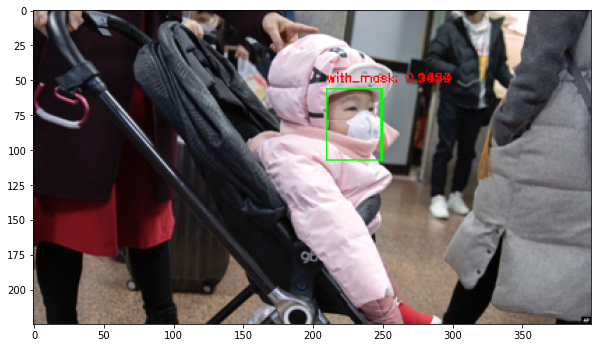

In [ ]:
import cv2 
import matplotlib.pyplot as plt

img_array= cv2.cvtColor(cv2.imread('/content/face/images/maksssksksss102.png'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(export_model, img_array)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [ ]:
img_array = img_array[tf.newaxis, ...]
boxes, socres, classes, valid_len = export_model.f(img_array) 

### 학습된 모델을 이용하여 Video Detection 수행하기

In [ ]:
%cd /content
!mkdir /content/data

/content
mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
def detected_video(model, input_path, output_path, do_print=True):
  cap = cv2.VideoCapture(input_path)
  codec = cv2.VideoWriter_fourcc(*'XVID')
  vid_size = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  vid_fps= cap.get(cv2.CAP_PROP_FPS)

  vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
  frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print('총 frame 수:',frame_cnt)

  start_time = time.time()
  while True:
    hasFrame , img_frame = cap.read()
    if not hasFrame:
      print('더 이상 처리할 frame이 없습니다.')
      break
    stime =time.time()
    img_frame = get_detected_img(model, img_frame, is_print=False)
    if do_print:
      print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
    vid_writer.write(img_frame)
    
  vid_writer.release()
  cap.release()
  print('최종 detection 완료 수행 시간:', round(time.time() - start_time, 4)) 

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 서울거리.mp4 to 서울거리.mp4
User uploaded file "서울거리.mp4" with length 14713021 bytes


In [ ]:
input_path = '/content/서울거리.mp4'
output_path = '/content/서울거리_out.mp4'
detected_video(export_model, input_path, output_path, score_threshold, do_print=True)